In [1]:
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import quant_utils.data_moudle as dm
from dateutil.parser import parse
from quant_utils.performance import periods_performance, Performance
from quant_utils.constant import DB_CONN_JJTG_DATA,DB_CONN_JY_LOCAL
sys.path.append("D:/FundResearch/")
from portfolio.portfolio_backtest_new import PortfolioBacktest

In [4]:
def get_del_jsid(update_time):
    query_sql = f"""
    SELECT
        a.TABLENAME,
        a.RECID
    FROM
        `jy_local`.`jydb_deleterec` a
        JOIN information_schema.TABLES b ON a.TABLENAME = b.TABLE_NAME 
    WHERE
        1 = 1 
        AND a.XGRQ >= '{update_time}'
        and a.XGRQ <= date_add({update_time}, interval 1 day)
        AND b.TABLE_SCHEMA = 'jy_local' 
    ORDER BY
        XGRQ, TABLENAME
    """
    temp = DB_CONN_JJTG_DATA.exec_query(query_sql)
    print(temp)
    df_list = []
    for table_name in temp["TABLENAME"].unique():
        print(table_name)
        id_list = temp.query(f"TABLENAME == '{table_name}'")["RECID"].astype("str").tolist()
        if not id_list:
            continue
        id_str = ','.join(id_list)
        query_sql = f"""
        select JSID from jy_local.{table_name} where ID in ({id_str})
        """
        print(query_sql)
        df = DB_CONN_JY_LOCAL.exec_query(query_sql)
        if not df.empty:
            df["TABLE_NAME"] = table_name
            df_list.append(df)
    df = pd.concat(df_list)
    return df

In [5]:
get_del_jsid("20231101")

                      TABLENAME         RECID
0      MF_InvestTargetCriterion  751839307000
1      MF_InvestTargetCriterion  750159918406
2      MF_InvestTargetCriterion  751839551144
3      MF_InvestTargetCriterion  751841282147
4      MF_InvestTargetCriterion  751839551147
...                         ...           ...
94913            MF_ScaleChange  752233456356
94914            MF_ScaleChange  752233456358
94915            MF_ScaleChange  752233456360
94916            MF_ScaleChange  752233456362
94917            MF_ScaleChange  752233456364

[94918 rows x 2 columns]
MF_InvestTargetCriterion

        select JSID from jy_local.MF_InvestTargetCriterion where ID in (751839307000,750159918406,751839551144,751841282147,751839551147,751736954600,751736954617,751734831863,751736954632,751940755591,751940755593,751604030057,751840631607,751839307004,751838652593,751494512563,751840755864,751604030059,750159806463,751839307018,751736488553,751842044168,751736488555,751736954622,750159918401

,JSID,TABLE_NAME
0,739410763642,MF_InvestTargetCriterion
1,716723751553,MF_InvestTargetCriterion
2,712285755964,MF_InvestTargetCriterion
3,711791978468,MF_InvestTargetCriterion
4,711791978459,MF_InvestTargetCriterion
...,...,...
12831,752181327169,MF_FCNumOfManager
12832,752181327171,MF_FCNumOfManager
12833,752181327173,MF_FCNumOfManager
12834,752181327175,MF_FCNumOfManager


In [3]:
def get_fund_tanche(trade_dt):
    query_sql = f"""
    WITH a AS (
        SELECT
            a.TICKER_SYMBOL,
            a.TRADE_DT,
            b.LEVEL_1,
            b.LEVEL_2,
            b.LEVEL_3,
            F_AVGRETURN_QUARTER,
            F_AVGRETURN_HALFYEAR,
            F_AVGRETURN_YEAR,
            F_AVGRETURN_TWOYEA,
            F_AVGRETURN_THREEYEAR,
            F_MAXDOWNSIDE_QUARTER,
            F_MAXDOWNSIDE_HALFYEAR,
            F_MAXDOWNSIDE_YEAR,
            F_MAXDOWNSIDE_TWOYEAR,
            F_MAXDOWNSIDE_THREEYEAR,
            F_STDARDDEV_HALFYEAR,
            F_STDARDDEV_YEAR,
            F_STDARDDEV_TWOYEAR,
            F_STDARDDEV_THREEYEAR 
        FROM
            fund_performance a
            JOIN fund_type_own b ON a.TICKER_SYMBOL = b.TICKER_SYMBOL 
        WHERE
            1 = 1 
            AND a.TRADE_DT = '{trade_dt}' 
            AND b.REPORT_DATE = ( SELECT max( REPORT_DATE ) FROM fund_type_own WHERE PUBLISH_DATE < '{trade_dt}' ) 
            AND b.LEVEL_1 IN ( '主动权益' ) 
            AND a.F_STDARDDEV_TWOYEAR IS NOT NULL 
        ),
        b AS (
        SELECT
            TICKER_SYMBOL,
            TRADE_DT,
            LEVEL_1,
            LEVEL_2,
            LEVEL_3,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_AVGRETURN_QUARTER )* 100, 2 ) AS F_AVGRETURN_QUARTER,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_AVGRETURN_HALFYEAR )* 100, 2 ) AS F_AVGRETURN_HALFYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_AVGRETURN_YEAR )* 100, 2 ) AS F_AVGRETURN_YEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_AVGRETURN_TWOYEA )* 100, 2 ) AS F_AVGRETURN_TWOYEA,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_AVGRETURN_THREEYEAR )* 100, 2 ) AS F_AVGRETURN_THREEYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_MAXDOWNSIDE_QUARTER )* 100, 2 ) AS F_MAXDOWNSIDE_QUARTER,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_MAXDOWNSIDE_HALFYEAR )* 100, 2 ) AS F_MAXDOWNSIDE_HALFYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_MAXDOWNSIDE_YEAR )* 100, 2 ) AS F_MAXDOWNSIDE_YEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_MAXDOWNSIDE_TWOYEAR )* 100, 2 ) AS F_MAXDOWNSIDE_TWOYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_MAXDOWNSIDE_THREEYEAR )* 100, 2 ) AS F_MAXDOWNSIDE_THREEYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_STDARDDEV_HALFYEAR )* 100, 2 ) AS F_STDARDDEV_HALFYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_STDARDDEV_YEAR )* 100, 2 ) AS F_STDARDDEV_YEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_STDARDDEV_TWOYEAR )* 100, 2 ) AS F_STDARDDEV_TWOYEAR,
            ROUND( PERCENT_RANK() over ( PARTITION BY TRADE_DT ORDER BY F_STDARDDEV_THREEYEAR )* 100, 2 ) AS F_STDARDDEV_THREEYEAR 
        FROM
            a 
        ),
        c AS (
        SELECT
            TICKER_SYMBOL,
            TRADE_DT,
            LEVEL_1,
            LEVEL_2,
            LEVEL_3,
            ( F_AVGRETURN_HALFYEAR + F_AVGRETURN_YEAR + F_AVGRETURN_TWOYEA )/ 3 AS RETURN_SCORE,
            ( F_MAXDOWNSIDE_HALFYEAR + F_MAXDOWNSIDE_YEAR + F_MAXDOWNSIDE_TWOYEAR )/ 3 AS MAXDD_SCORE,
            100- ( F_STDARDDEV_HALFYEAR + F_STDARDDEV_YEAR + F_STDARDDEV_TWOYEAR )/ 3 AS VOL_SCORE 
        FROM
            b 
        ),
        d AS (
        SELECT
            d.SEC_SHORT_NAME,
            c.*,
            RETURN_SCORE * 0.3 + MAXDD_SCORE * 0.35 + VOL_SCORE * 0.35 AS TOTAL_SCORE 
        FROM
            c
            JOIN fund_info d ON c.TICKER_SYMBOL = d.TICKER_SYMBOL 
        WHERE
            1 = 1 
            AND d.IS_MAIN = 1 
            AND d.IS_ILLIQUID = 0 
        ORDER BY
            TOTAL_SCORE DESC 
        ),
        e AS ( SELECT d.TICKER_SYMBOL, d.TRADE_DT, NTILE( 10 ) over ( PARTITION BY TRADE_DT ORDER BY TOTAL_SCORE ) AS PORTFOLIO_NAME FROM d ),
        f AS ( SELECT PORTFOLIO_NAME, count( PORTFOLIO_NAME ) AS num FROM e GROUP BY PORTFOLIO_NAME ) SELECT
        e.*,
        100 / f.num  AS START_WEIGHT 
    FROM
        e
        JOIN f ON e.PORTFOLIO_NAME = f.PORTFOLIO_NAME
    """
    return DB_CONN_JJTG_DATA.exec_query(query_sql)

In [4]:
dates_list = dm.get_period_end_date(
    start_date='20231031', 
    end_date="20231101",
    period="m"
)
result_list = []
for date in dates_list:
    print(date)
    temp = get_fund_tanche(date)
    temp["TRADE_DT"] = dm.offset_trade_dt(date, 2)
    result_list.append(temp)

20231031


In [5]:
result = pd.concat(result_list)
result["PORTFOLIO_NAME"] = result["PORTFOLIO_NAME"].apply(lambda s: str(s).rjust(2,"0"))
result["TEST_CODE"] = '13'
DB_CONN_JJTG_DATA.upsert(result, table='portfolio_backtest_weights')

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为1523行!


In [20]:
result.to_excel("d:/jisuan.xlsx")

<Axes: xlabel='TRADE_DT'>

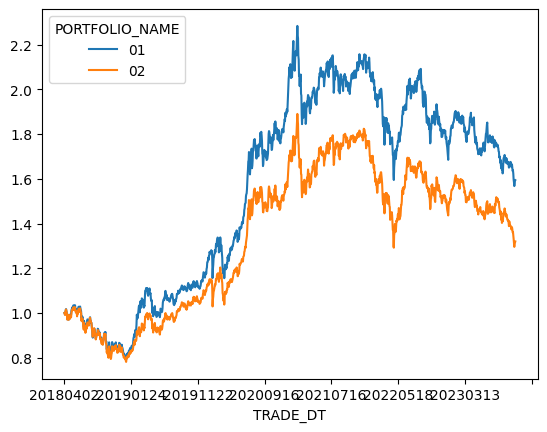

In [25]:
indictaor_list = ["27"]
test = PortfolioBacktest(indictaor_list)
nav = test.get_backtest_nav()
ret_df = nav.pivot(index="TRADE_DT", columns= "PORTFOLIO_NAME", values="NAV")
ret_df.plot()

In [4]:
def get_barra_tranche(report_date):
    query_sql = f"""
    WITH a AS (
        SELECT
            a.REPORT_DATE,
            b.SEC_SHORT_NAME,
            a.TICKER_SYMBOL,
            LEVEL_1,
            LEVEL_2,
            LEVEL_3,
            ( a.BETA + a.RESVOL )/ 2 AS VOLATILITY,
            ( a.MOMENTUM + a.INDMOM + a.STREVRSL + a.SEASON )/ 4 AS MOMENTUM,
            a.SIZE AS SIZE,
            a.MIDCAP AS MIDCAP,
            ( a.LEVERAGE + a.EARNVAR + a.EARNQLTY + a.PROFIT + a.INVSQLTY )/ 5 AS QUALITY,
            a.LIQUIDTY,
            a.GROWTH,
            ( a.BTOP + a.EARNYILD + a.LTREVRSL )/ 3 AS `VALUE`,
            a.ANALSENTI,
            a.DIVYILD 
        FROM
            fund_derivatives_holdings_barra_exposure a
            JOIN fund_type_own b ON a.REPORT_DATE = b.REPORT_DATE 
            AND a.TICKER_SYMBOL = b.TICKER_SYMBOL
            JOIN fund_asset_own c ON c.TICKER_SYMBOL = a.TICKER_SYMBOL 
            AND c.REPORT_DATE = a.REPORT_DATE
            JOIN fund_info d ON d.TICKER_SYMBOL = a.TICKER_SYMBOL 
        WHERE
            1 = 1 
            AND a.`REPORT_DATE` = '{report_date}' 
            AND b.LEVEL_1 = '主动权益' 
            AND c.NET_ASSET >= 100000000 
            AND d.IS_MAIN = 1 
        ) SELECT
        REPORT_DATE,
        TICKER_SYMBOL,
        SEC_SHORT_NAME,
        LEVEL_1,
        LEVEL_2,
        LEVEL_3,-- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY VOLATILITY )* 100, 2 ) AS VOLATILITY,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY MOMENTUM )* 100, 2 ) AS MOMENTUM,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY SIZE )* 100, 2 ) AS SIZE,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY MIDCAP )* 100, 2 ) AS MIDCAP,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY QUALITY )* 100, 2 ) AS QUALITY,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY LIQUIDTY )* 100, 2 ) AS LIQUIDTY,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY GROWTH )* 100, 2 ) AS GROWTH,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY `VALUE` )* 100, 2 ) AS VALUE,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY ANALSENTI )* 100, 2 ) AS ANALSENTI,
    -- 	round( PERCENT_RANK() over ( PARTITION BY REPORT_DATE ORDER BY DIVYILD )* 100, 2 ) AS DIVYILD
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY VOLATILITY ) AS VOLATILITY,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY MOMENTUM ) AS MOMENTUM,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY SIZE ) AS SIZE,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY MIDCAP ) AS MIDCAP,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY QUALITY ) AS QUALITY,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY LIQUIDTY ) AS LIQUIDTY,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY GROWTH ) AS GROWTH,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY `VALUE` ) AS `VALUE`,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY ANALSENTI ) AS ANALSENTI,
        NTILE(10) over ( PARTITION BY REPORT_DATE ORDER BY DIVYILD ) AS DIVYILD 
    FROM
        a 
    """
    return DB_CONN_JJTG_DATA.exec_query(query_sql)
df = get_barra_tranche("20230630")

In [22]:
dates_list = dm.get_period_end_date(
    start_date='20140808', 
    end_date="20231028",
    period="m"
)


In [2]:
dates_list = []
for year in range(2010, 2023):
    dates_list.extend(str(year)+date for date in ["0630", "1231"])
dates_list.append("20230630")
dates_list

['20100630',
 '20101231',
 '20110630',
 '20111231',
 '20120630',
 '20121231',
 '20130630',
 '20131231',
 '20140630',
 '20141231',
 '20150630',
 '20151231',
 '20160630',
 '20161231',
 '20170630',
 '20171231',
 '20180630',
 '20181231',
 '20190630',
 '20191231',
 '20200630',
 '20201231',
 '20210630',
 '20211231',
 '20220630',
 '20221231',
 '20230630']

In [5]:
result_list = []
for date in dates_list:
    print(date)
    temp = get_barra_tranche(date)
    if "0630" in date:
        temp["TRADE_DT"] = dm.offset_trade_dt(date, 40)
    else:
        temp["TRADE_DT"] = dm.offset_trade_dt(date, 60)
    result_list.append(temp)
result = pd.concat(result_list)
barra_list = [
    "VOLATILITY", "MOMENTUM", "SIZE", 
    "MIDCAP", "QUALITY", "LIQUIDTY", 
    "GROWTH", "VALUE", "ANALSENTI", "DIVYILD"
]

for test_code, barra in enumerate(barra_list, start=14):
    temp = result[["TRADE_DT", "TICKER_SYMBOL", barra]]
    temp["TEST_CODE"] = test_code
    temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
    temp.rename(columns={barra: "PORTFOLIO_NAME"}, inplace=1)
    temp_weight =  100/(temp.groupby(by=["TRADE_DT", "PORTFOLIO_NAME"])[["PORTFOLIO_NAME"]].count())
    temp_weight = temp_weight.rename(columns={"PORTFOLIO_NAME": "START_WEIGHT"}).reset_index()
    temp = temp.merge(temp_weight)
    DB_CONN_JJTG_DATA.upsert(temp, table="portfolio_backtest_weights")

20100630
20101231
20110630
20111231
20120630
20121231
20130630
20131231
20140630
20141231
20150630
20151231
20160630
20161231
20170630
20171231
20180630
20181231
20190630
20191231
20200630
20201231
20210630
20211231
20220630
20221231
20230630


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!
写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["TEST_CODE"] = test_code
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[barra] = temp[barra].apply(lambda s: str(s).rjust(2,"0"))
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_9144\2863144556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为32870行!


,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复,TEST_CODE,组合名称
0,20140902,20231031,1.062977,0.082198,0.257065,0.319756,0.571049,0.143942,20190103,557,13,01
0,20140902,20231031,0.947262,0.075405,0.247268,0.304952,0.54816,0.13756,20190103,557,13,02
0,20140902,20231031,1.031554,0.080388,0.239733,0.335322,0.509133,0.157891,20190103,552,13,03
0,20140902,20231031,1.18509,0.089008,0.233948,0.380461,0.483014,0.184277,20150915,1752,13,04
0,20140902,20231031,1.256871,0.092855,0.225397,0.411961,0.472334,0.196587,20150915,1750,13,05
...,...,...,...,...,...,...,...,...,...,...,...,...
0,20140902,20231031,1.38206,0.09931,0.208086,0.477253,0.426396,0.232905,20150915,1623,23,09
0,20140902,20231031,1.692648,0.114106,0.194292,0.587288,0.401732,0.284034,20160128,726,23,10
0,20140902,20231031,1.688976,0.11394,0.192529,0.591804,0.397156,0.286889,20160128,1432,24,01
0,20140902,20231031,1.695976,0.114256,0.183174,0.623753,0.367321,0.311052,20160128,663,25,01


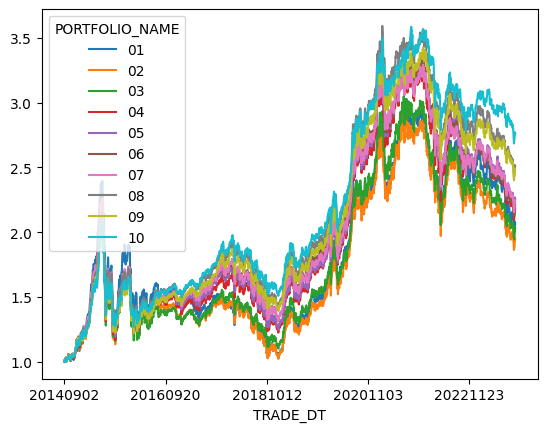

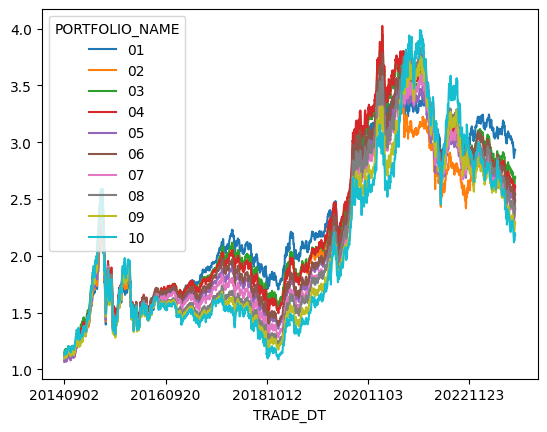

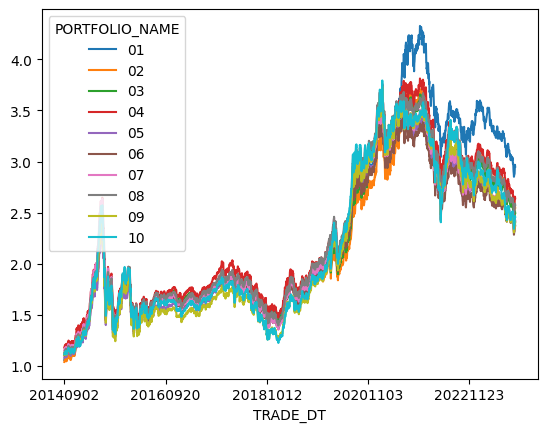

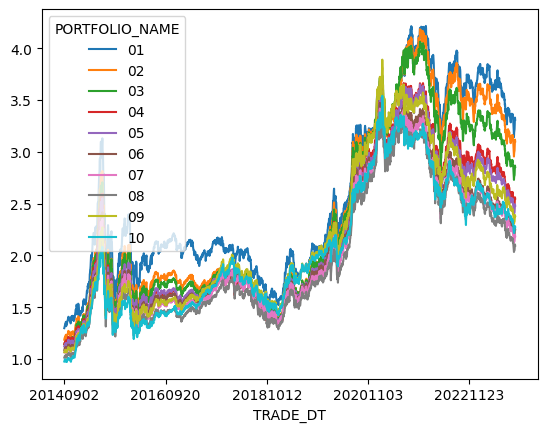

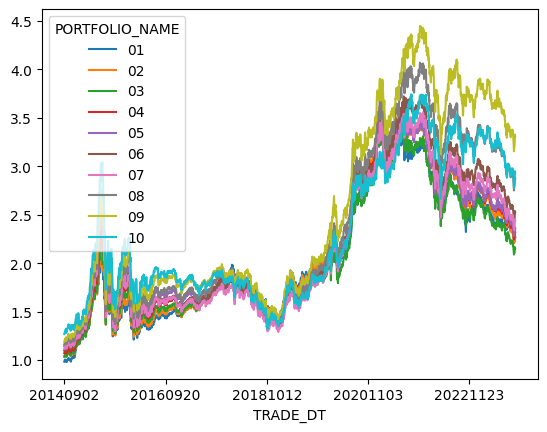

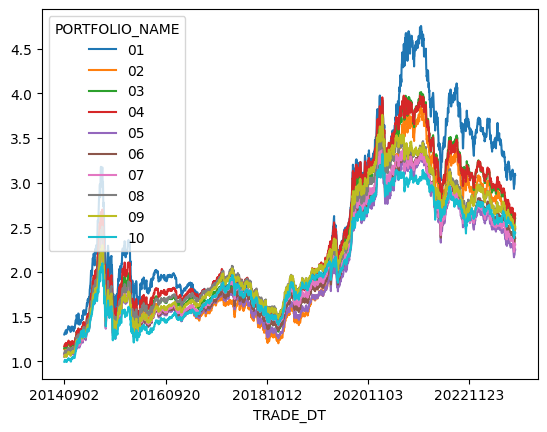

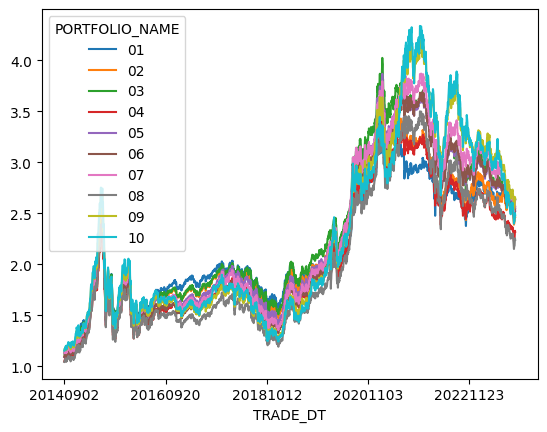

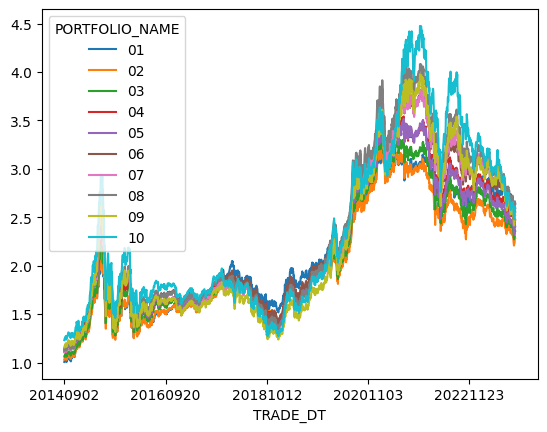

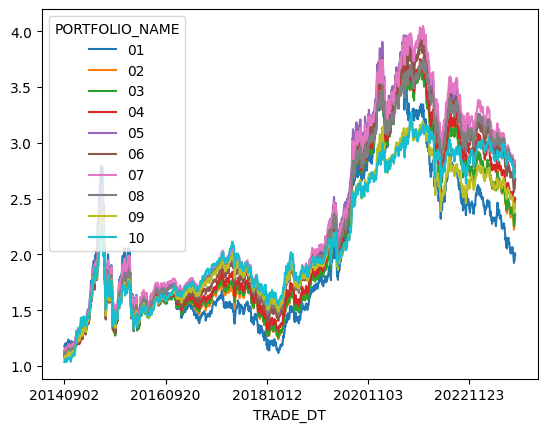

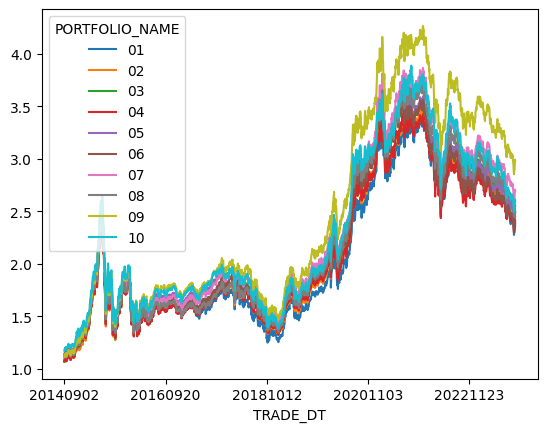

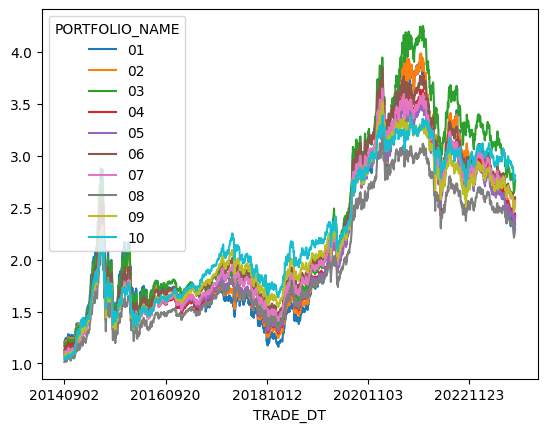

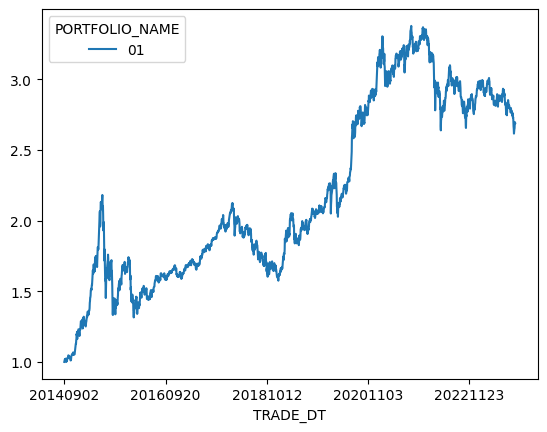

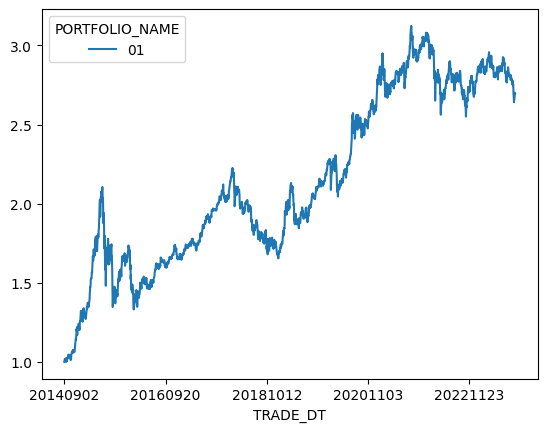

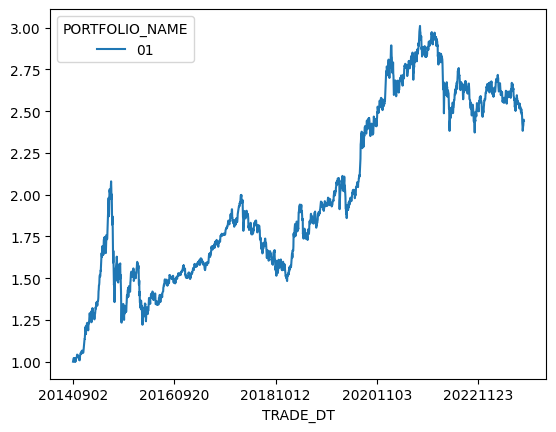

In [37]:
indictaor_list = list(range(13,27))
test = PortfolioBacktest(indictaor_list)
nav = test.get_backtest_nav()
nav = nav.query("TRADE_DT >= '20140902'")
perf_df = []
for indicator in indictaor_list:
    ret_df = nav.query(f"TEST_CODE == '{indicator}'")
    ret_df = ret_df.pivot(index="TRADE_DT", columns= "PORTFOLIO_NAME", values="NAV")
    ret_df.plot()
    for col in ret_df.columns:
        temp = Performance(ret_df[col]).stats().T
        temp["TEST_CODE"] = indicator
        temp["组合名称"] = col
        perf_df.append(temp)
perf_df = pd.concat(perf_df)
perf_df

In [38]:
nav

,TEST_CODE,TEST_NAME,PORTFOLIO_NAME,TRADE_DT,LOG_RETURN_RATE,NAV,BENCHMARK_NAV,FUND_MEDIAN_NAV,ALPHA
0,13,低波打分模型,01,20140902,0.000000,1.000000,1.000000,1.000000,1.000000
1,13,低波打分模型,02,20140902,0.000000,1.000000,1.000000,1.000000,1.000000
2,13,低波打分模型,03,20140902,0.000000,1.000000,1.000000,1.000000,1.000000
3,13,低波打分模型,04,20140902,0.000000,1.000000,1.000000,1.000000,1.000000
4,13,低波打分模型,05,20140902,0.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
349046,26,低波9+价值9+分红9,01,20231025,0.495061,2.408657,1.737955,1.569662,1.670702
349047,26,低波9+价值9+分红9,01,20231026,0.301472,2.415929,1.742199,1.573446,1.673731
349048,26,低波9+价值9+分红9,01,20231027,1.163999,2.444215,1.774020,1.596632,1.670196
349049,26,低波9+价值9+分红9,01,20231030,0.197796,2.449054,1.797774,1.614782,1.651281


In [45]:
perf_df.to_excel("d:/测算2.xlsx")

In [39]:
nav["NAME"] = nav["TEST_NAME"] + "_" + nav["PORTFOLIO_NAME"]

In [44]:
# nav = nav.pivot(index="TRADE_DT", columns="NAME", values="NAV")
nav = nav/nav.loc["20140902", :]
nav.to_excel("d:/净值1.xlsx")

In [4]:
def get_sh_tranche(trade_dt):
    query_sql = f"""
    WITH dt AS ( SELECT max( TRADE_DT ) AS TRADE_DT FROM portfolio_backtest_weights WHERE TEST_CODE = '23' AND TRADE_DT <= '{trade_dt}' ) SELECT
    a.TICKER_SYMBOL
    # e.SEC_SHORT_NAME,
    # a.PORTFOLIO_NAME AS '低波分组',
    # b.PORTFOLIO_NAME AS "价值分组",
    # c.PORTFOLIO_NAME AS "红利分组" 
    FROM
        portfolio_backtest_weights a
        JOIN dt
        JOIN portfolio_backtest_weights b ON a.TICKER_SYMBOL = b.TICKER_SYMBOL 
        AND b.TRADE_DT = dt.TRADE_DT
        JOIN portfolio_backtest_weights c ON a.TICKER_SYMBOL = c.TICKER_SYMBOL 
        AND c.TRADE_DT = dt.TRADE_DT
        JOIN fund_info e ON e.TICKER_SYMBOL = a.TICKER_SYMBOL

    WHERE
        1 = 1 
        AND ( a.TRADE_DT = '{trade_dt}' AND a.TEST_CODE = '13' AND a.PORTFOLIO_NAME IN ( "08", "09", "10" ) ) 
        AND ( b.TEST_CODE = '21' AND b.PORTFOLIO_NAME IN (  "10" ) ) 
        AND ( c.TEST_CODE = '23' AND c.PORTFOLIO_NAME IN (   "10" ) ) 
    """
    return DB_CONN_JJTG_DATA.exec_query(query_sql)

In [6]:
dates_list = dm.get_period_end_date(
    start_date='20231031', 
    end_date="20231103",
    period="m"
)
result_list = []
for date in dates_list:
    tem_date = dm.offset_trade_dt(date, 2)
    temp = get_sh_tranche(tem_date)
    temp["TRADE_DT"] = tem_date
    print(tem_date, temp.shape[0])
    result_list.append(temp)
result_df = pd.concat(result_list)

temp = result_df.groupby("TRADE_DT")["TICKER_SYMBOL"].count().reset_index()
temp["TICKER_SYMBOL"] = 100/temp["TICKER_SYMBOL"]
temp.rename(columns={"TICKER_SYMBOL": "START_WEIGHT"}, inplace=1)
result_df = result_df.merge(temp)
result_df["TEST_CODE"] = 25
result_df["PORTFOLIO_NAME"] = '01'
DB_CONN_JJTG_DATA.upsert(result_df, table='portfolio_backtest_weights')

20231102 133
写入192.20.57.208:chentiancheng--portfolio_backtest_weights-受影响行数为133行!


<Axes: xlabel='TRADE_DT'>

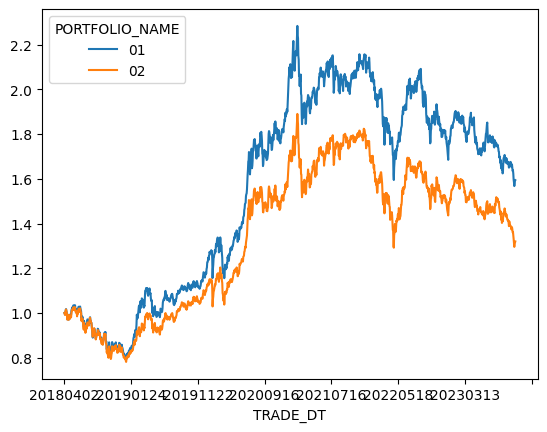

In [23]:
indictaor_list = ["27"]
test = PortfolioBacktest(indictaor_list)
# test.update_backtest()
nav = test.get_backtest_nav()
ret_df = nav.pivot(index="TRADE_DT", columns= "PORTFOLIO_NAME", values="NAV")
ret_df.plot()

In [24]:
perf_list = []
for col in ret_df.columns:
    temp = Performance(ret_df[col]).stats().T
    perf_list.append(temp)
perf_df = pd.concat(perf_list)
perf_df

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,20180402,20231026,0.593892,0.087299,0.202159,0.431833,0.313629,0.278351,20231023,99999
0,20180402,20231026,0.319883,0.051092,0.195722,0.261043,0.316469,0.161444,20220426,99999


In [16]:
temp

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,20140902,20231025,1.408657,0.100832,0.188081,0.536107,0.412835,0.244242,20160128,1442
